In [72]:
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Dense, Input
from keras.utils import plot_model
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
def preprocess(path,unlabeled=False): # Function for preprocessing the data
    Data = pd.read_csv(path, header=None)
    columns = [f'feature_{i+1}' for i in range(Data.shape[1])]
    Data.columns = columns
    if unlabeled==False:
        Data.rename(columns={f'{columns[-1]}':'label'},inplace=True)
    return Data

In [3]:
Train_labeled_data=preprocess('/kaggle/input/iitm-cs6910-assignment-dataset/task3-20240306T145505Z-001/task3/training_data_set_24_labeled.csv',False)
Train_unlabeled_data=preprocess('/kaggle/input/iitm-cs6910-assignment-dataset/task3-20240306T145505Z-001/task3/training_data_set_24_unlabeled.csv',True)
Test_data=preprocess('/kaggle/input/iitm-cs6910-assignment-dataset/task3-20240306T145505Z-001/task3/testing_data_set_24.csv')
Val_data=preprocess('/kaggle/input/iitm-cs6910-assignment-dataset/task3-20240306T145505Z-001/task3/validation_data_set_24.csv')

In [4]:
Train_labeled_data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,label
0,0.184351,0.260366,0.097935,0.206766,0.255293,0.188745,0.079312,0.056171,0.152396,0.246005,...,0.260366,0.174001,0.120221,0.070403,0.064377,0.166789,0.065881,0.041707,0.241522,0.0
1,0.258150,0.122753,0.192504,0.041621,0.130102,0.057836,0.051601,0.123496,0.174314,0.258150,...,0.160983,0.126839,0.131783,0.084628,0.194930,0.258150,0.258150,0.189442,0.171489,0.0
2,0.175689,0.067131,0.123794,0.078015,0.243021,0.158522,0.126465,0.049368,0.145203,0.187855,...,0.202737,0.243021,0.184991,0.243021,0.231355,0.243021,0.142975,0.106789,0.160175,0.0
3,0.050744,0.019495,0.035189,0.049381,0.253401,0.025830,0.020485,0.007811,0.036225,0.015371,...,0.182935,0.253401,0.140164,0.211612,0.253401,0.182359,0.253401,0.253401,0.253401,0.0
4,0.230728,0.071674,0.058397,0.130275,0.180351,0.293367,0.222687,0.090680,0.134349,0.095540,...,0.099883,0.180046,0.180148,0.187977,0.293367,0.290719,0.155117,0.076280,0.138690,0.0


In [5]:
Train_unlabeled_data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36
0,0.287300,0.188751,0.156409,0.287300,0.287300,0.211518,0.139102,0.287300,0.280853,0.042219,...,0.000000,0.084097,0.046035,0.069387,0.055658,0.141755,0.113474,0.093767,0.177397,0.061876
1,0.198184,0.151456,0.039215,0.044318,0.193607,0.133913,0.160893,0.098311,0.126627,0.109150,...,0.072344,0.257498,0.176985,0.147437,0.142221,0.193323,0.193953,0.070509,0.255965,0.257498
2,0.160540,0.012436,0.231843,0.140667,0.247599,0.107541,0.078808,0.025844,0.123571,0.161976,...,0.143664,0.247599,0.086855,0.215706,0.149646,0.178233,0.189451,0.173096,0.243009,0.247599
3,0.255071,0.255071,0.255071,0.255071,0.255071,0.164713,0.255071,0.100501,0.076231,0.201872,...,0.255071,0.021323,0.022369,0.140653,0.025872,0.048711,0.111879,0.080779,0.042511,0.038879
4,0.166231,0.055222,0.093225,0.076944,0.090563,0.068452,0.075874,0.142515,0.188977,0.064491,...,0.113067,0.125742,0.228519,0.155023,0.263467,0.255462,0.263467,0.206489,0.093396,0.076454


In [6]:
Test_data['label'].value_counts()

label
2.0    59
4.0    54
0.0    50
1.0    45
3.0    42
Name: count, dtype: int64

In [7]:
Val_data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,label
0,0.274234,0.274234,0.113289,0.011855,0.052094,0.024821,0.023587,0.047950,0.044647,0.075815,...,0.274234,0.253696,0.153283,0.065087,0.101397,0.124654,0.140817,0.030477,0.274234,4.0
1,0.228062,0.180099,0.135517,0.124941,0.111409,0.021823,0.064625,0.010928,0.072755,0.167774,...,0.148664,0.224846,0.151569,0.200898,0.228062,0.095704,0.228062,0.167763,0.222238,1.0
2,0.250422,0.250422,0.109479,0.043443,0.224127,0.119973,0.103059,0.212480,0.250422,0.250422,...,0.193479,0.241097,0.199695,0.128365,0.096818,0.067651,0.062318,0.081312,0.095624,1.0
3,0.046513,0.017087,0.126997,0.138123,0.108609,0.029538,0.018045,0.027438,0.083596,0.092759,...,0.220139,0.138260,0.089466,0.167423,0.233328,0.233328,0.233328,0.233328,0.233328,0.0
4,0.169945,0.107052,0.137326,0.244827,0.245115,0.024856,0.024106,0.000000,0.046160,0.049538,...,0.276609,0.276609,0.052773,0.136187,0.073037,0.162011,0.136513,0.149412,0.276609,0.0


## Model architecture

In [8]:
class AutoEncoder(Model):
    def __init__(self,hidden_dim,bottle_neck_dim,name):
        super(AutoEncoder, self).__init__()  
        """
        Initialize the model parameters
        """
        self.hidden=hidden_dim
        self.bottle_neck=bottle_neck_dim
        self.name=name
        
    def Encoder(self, inputs):
        """
        Functional_parameters
        """
        self.input_shape=inputs.shape[1]
        x=Dense(units=self.hidden,name=self.name+'_encoder_h',activation = 'tanh')(inputs)
        x=Dense(units=self.bottle_neck,name=self.name+'_bottleneck')(x)
        
        return x
        
    def Decoder(self, inputs):
        x = Dense(units=self.hidden,name=self.name+'_decoder_h',activation = 'tanh')(inputs)
        x = Dense(units=self.input_shape,name=self.name+'_decoder_out')(x)
        
        return x
    
    def Full_model(self,inputs):
        """
        Full model is required for training
        """
        bottle_neck = self.Encoder(inputs)
        reconstructed = self.Decoder(bottle_neck)
        
        return reconstructed

In [9]:
AE1_hidden=32
AE1_bottle_neck=28
AE2_hidden=24
AE2_bottle_neck=16
AE3_hidden=12
AE3_bottle_neck=8

Inputs_AE1 = Input(shape=(36,),name = 'Input_AE1')
Inputs_AE2 = Input(shape=(AE1_bottle_neck,),name = 'Input_AE2')
Inputs_AE3 = Input(shape=(AE2_bottle_neck,),name = 'Input_AE3')

AE1=AutoEncoder(AE1_hidden,AE1_bottle_neck,'AE1')
AE2=AutoEncoder(AE2_hidden,AE2_bottle_neck,'AE2')
AE3=AutoEncoder(AE3_hidden,AE3_bottle_neck,'AE3')

outputs_AE1=AE1.Full_model(Inputs_AE1)
Model_AE1 = Model(inputs=Inputs_AE1,outputs=outputs_AE1, name = 'AE1')

outputs_AE2=AE2.Full_model(Inputs_AE2)
Model_AE2 = Model(inputs=Inputs_AE2,outputs=outputs_AE2, name = 'AE2')

outputs_AE3=AE3.Full_model(Inputs_AE3)
Model_AE3 = Model(inputs=Inputs_AE3,outputs=outputs_AE3, name = 'AE3')

In [10]:
Model_AE1.summary()

Model: "AE1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_AE1 (InputLayer)          │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AE1_encoder_h (Dense)           │ (None, 32)             │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AE1_bottleneck (Dense)          │ (None, 28)             │           924 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AE1_decoder_h (Dense)           │ (None, 32)             │           928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AE1_decoder_out (Dense)         │ (None, 36)             │         1,188 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,224 (16.50 KB)

 Trainable params: 4,224 (16.50 KB)

 Non-trainable params: 0 (0.00 B)

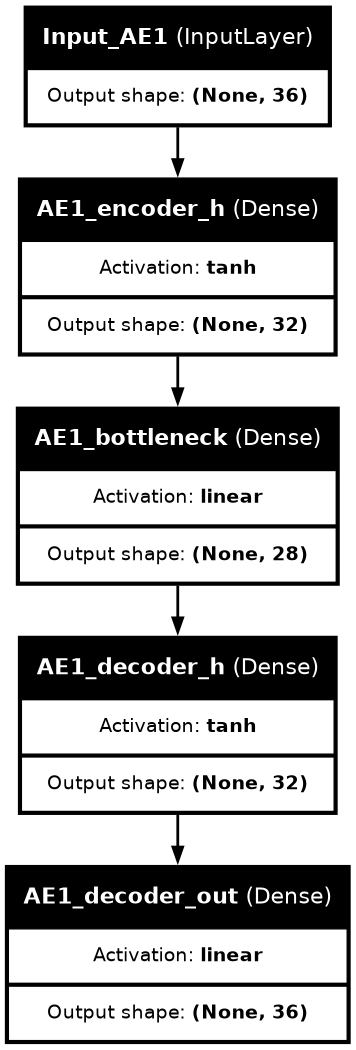

In [11]:
plot_model(Model_AE1,show_shapes=True,show_layer_names=True,dpi=100,show_layer_activations=True)

In [12]:
Model_AE2.summary()

Model: "AE2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_AE2 (InputLayer)          │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AE2_encoder_h (Dense)           │ (None, 24)             │           696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AE2_bottleneck (Dense)          │ (None, 16)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AE2_decoder_h (Dense)           │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AE2_decoder_out (Dense)         │ (None, 28)             │           700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,204 (8.61 KB)

 Trainable params: 2,204 (8.61 KB)

 Non-trainable params: 0 (0.00 B)

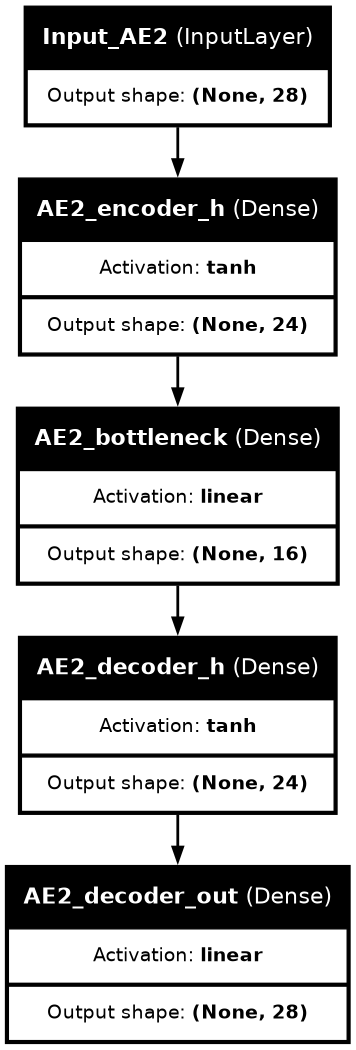

In [13]:
plot_model(Model_AE2,show_shapes=True,show_layer_names=True,dpi=100,show_layer_activations=True)

In [14]:
Model_AE3.summary()

Model: "AE3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_AE3 (InputLayer)          │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AE3_encoder_h (Dense)           │ (None, 12)             │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AE3_bottleneck (Dense)          │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AE3_decoder_h (Dense)           │ (None, 12)             │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AE3_decoder_out (Dense)         │ (None, 16)             │           208 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 624 (2.44 KB)

 Trainable params: 624 (2.44 KB)

 Non-trainable params: 0 (0.00 B)

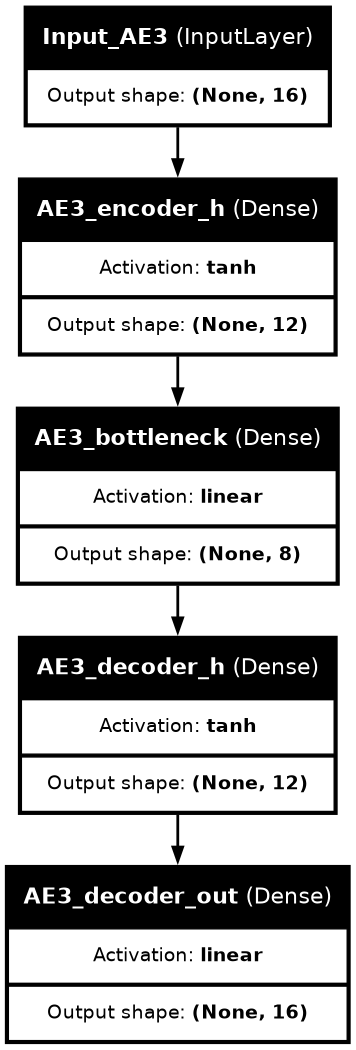

In [15]:
plot_model(Model_AE3,show_shapes=True,show_layer_names=True,dpi=100,show_layer_activations=True)

In [16]:
Model_AE1.compile(optimizer='Adam',loss='mse')
Model_AE2.compile(optimizer='Adam',loss='mse')
Model_AE3.compile(optimizer='Adam',loss='mse')

AEs=[Model_AE1, Model_AE2, Model_AE3]
Encoders = []

Unlabeled_train_data=Train_labeled_data.iloc[:,:-1].values
batch_size=32
for i,model in enumerate(AEs):
    print(f"\n Training on {i+1}st AE\n")
    early_stop = EarlyStopping(monitor = 'loss', mode = 'auto', min_delta = 0.001, patience = 15, verbose = 1)
    model.fit(Unlabeled_train_data,Unlabeled_train_data,verbose=1,batch_size=batch_size,epochs=100,callbacks=[early_stop])
    Encoder = Model(inputs=model.input,outputs=model.get_layer(f'AE{i+1}_bottleneck').output,name=f'AE_{i+1}')
    Unlabeled_train_data = Encoder(Unlabeled_train_data)
    Encoders.append(Encoder)


 Training on 1st AE

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0263
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100  
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063  
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043 
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041  
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037  
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032  
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030  
Epoch 13/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 
Epoch 14/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 
Epoch 15/100
24/24 ━━━━━━━━━━━

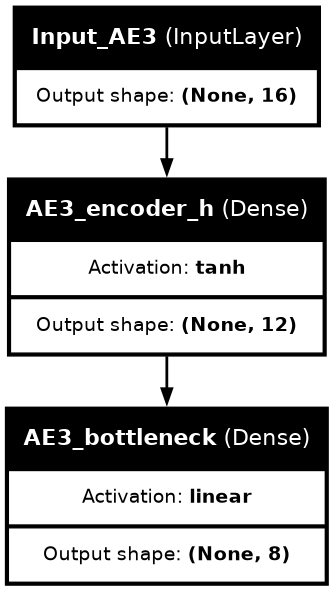

In [17]:
plot_model(Encoders[2],show_shapes=True,show_layer_names=True,dpi=100,show_layer_activations=True)

## Stacking the auto encoders

In [18]:
inputs = Input(shape=(36,),name = 'Input_stacked_AE')  # Define input shape based on your data

# Stack the encoders
encoded = inputs
for encoder in Encoders:
    encoded = encoder(encoded)

# Create the stacked encoder model
Stacked_encoder_model = Model(inputs=inputs, outputs=encoded, name = 'Stacked_autoencoder')

In [19]:
Stacked_encoder_model.summary()

Model: "Stacked_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_stacked_AE (InputLayer)   │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AE_1 (Functional)               │ (None, 28)             │         2,108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AE_2 (Functional)               │ (None, 16)             │         1,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AE_3 (Functional)               │ (None, 8)              │           308 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,512 (13.72 KB)

 Trainable params: 3,512 (13.72 KB)

 Non-trainable params: 0 (0.00 B)

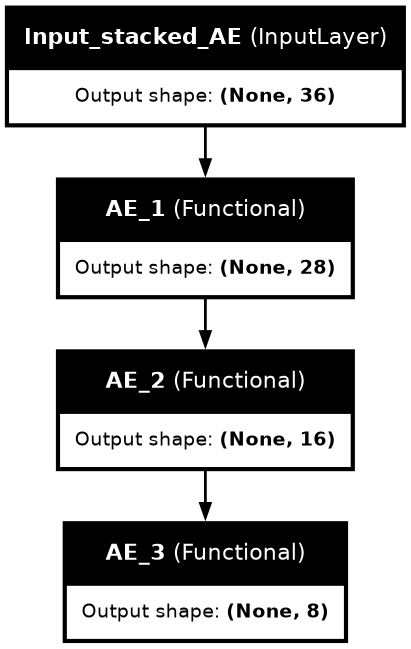

In [20]:
plot_model(Stacked_encoder_model,show_shapes=True,show_layer_names=True,dpi=100,show_layer_activations=True)

In [28]:
## Define the top layer for domain specific downstream applications
def classification_block(inputs):
    x = Dense(units=7,activation='relu',name='classifier_dense_1')(inputs)
    x = Dense(units=5,activation='softmax',name='output_layer')(x)
    
    return x

In [29]:
inputs = Input(shape=(36,))
btneck_output = Stacked_encoder_model(inputs)
output = classification_block(btneck_output)

Fine_tunable_model = Model(inputs=inputs,outputs=output)

In [34]:
Fine_tunable_model.layers[1].trainable=False

In [35]:
Fine_tunable_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Stacked_autoencoder             │ (None, 8)              │         3,512 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense_1 (Dense)      │ (None, 7)              │            63 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │            40 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,615 (14.12 KB)

 Trainable params: 103 (412.00 B)

 Non-trainable params: 3,512 (13.72 KB)

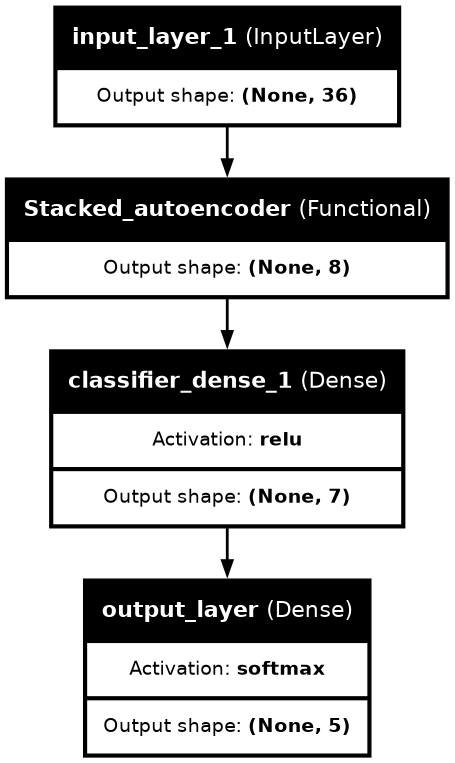

In [36]:
plot_model(Fine_tunable_model,show_shapes=True,show_layer_names=True,dpi=100,show_layer_activations=True)

In [73]:
def plot_learning_curve(history,name):
    plt.figure(figsize = (10, 8))
    plt.title(f"Learning curve with {name}", fontsize=22)
    plt.plot(history.history['loss'], label = 'Train loss')
    plt.plot(history.history['val_loss'], label = 'Validation loss')
    plt.legend()
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.show()
    
def Confusion_matrix(y_true,y_pred, data_name):
    labels = np.unique(y_true)
    CM = confusion_matrix(y_true, y_pred)
    plt.figure(figsize = (10, 8))
    plt.title(f"Confusion Matrix for {data_name} data", fontsize=18)
    sns.heatmap(CM, annot = True, cmap = 'Pastel2', fmt = 'd', linewidths = 1.0)
    plt.yticks(np.arange(len(labels)) + 0.5, labels, fontsize = 14, rotation = 'horizontal')
    plt.xticks(np.arange(len(labels)) + 0.5, labels, fontsize = 14)
    plt.xlabel("Predicted", fontsize = 16)
    plt.ylabel("Actual", fontsize = 16)
    plt.savefig(f"Conf_{data_name}.png")
    plt.show()

In [37]:
X_train=Train_labeled_data.iloc[:,:-1].values
y_train=Train_labeled_data.iloc[:,-1].values

X_val=Val_data.iloc[:,:-1].values
y_val=Val_data.iloc[:,-1].values

X_test=Test_data.iloc[:,:-1].values
y_test=Test_data.iloc[:,-1].values

Fine_tunable_model.compile(optimizer=Adam(learning_rate=0.001),loss=SparseCategoricalCrossentropy(), metrics=['acc'])
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'auto', min_delta = 0.000001, patience = 15, verbose = 1)
filepath = 'Best_model_epoch_{epoch}_val_loss_{val_loss:.4f}.keras'
chkpt = ModelCheckpoint(filepath = filepath, 
                        monitor = 'val_loss', 
                        save_best_only = True, verbose = 1)
history_frozen_wt = Fine_tunable_model.fit(X_train, y_train, batch_size = 64, validation_data = (X_val, y_val), validation_batch_size = 64, epochs = 1000, callbacks = [early_stop, chkpt])

Epoch 1/1000
 1/12 ━━━━━━━━━━━━━━━━━━━━ 10s 972ms/step - acc: 0.2812 - loss: 1.6061
Epoch 1: loss improved from inf to 1.63724, saving model to Best_model_epoch_1_val_loss_1.6147.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - acc: 0.1961 - loss: 1.6318 - val_acc: 0.2200 - val_loss: 1.6147
Epoch 2/1000
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.1875 - loss: 1.6310
Epoch 2: loss improved from 1.63724 to 1.62690, saving model to Best_model_epoch_2_val_loss_1.6062.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.1622 - loss: 1.6275 - val_acc: 0.2200 - val_loss: 1.6062
Epoch 3/1000
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - acc: 0.2188 - loss: 1.6011
Epoch 3: loss improved from 1.62690 to 1.61821, saving model to Best_model_epoch_3_val_loss_1.5988.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.1787 - loss: 1.6147 - val_acc: 0.2280 - val_loss: 1.5988
Epoch 4/1000
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.1406 - loss: 1.6194
Epoch 4: loss improved from 1.61821 to 1.60

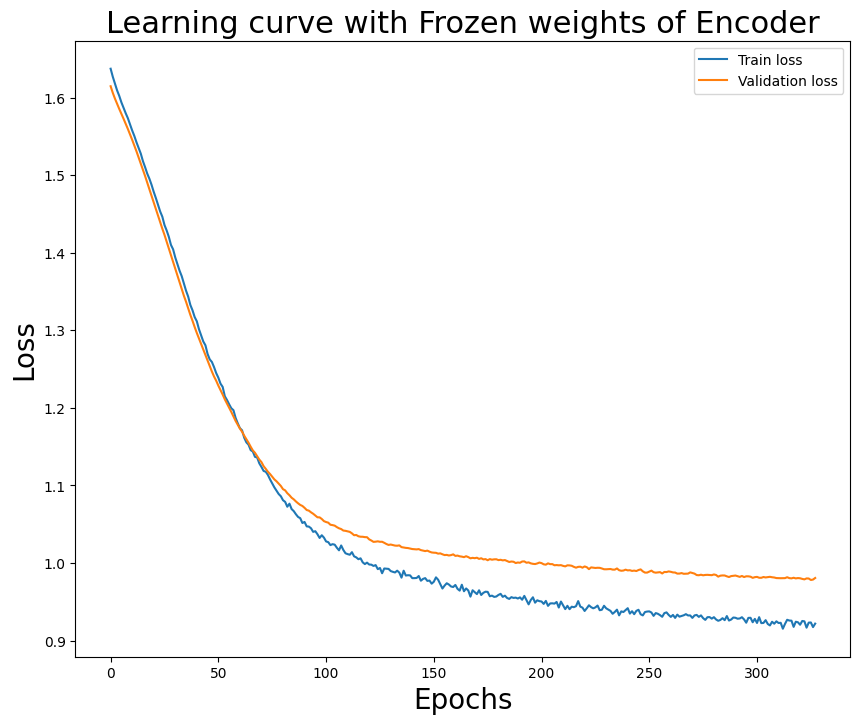

In [58]:
plot_learning_curve(history, "Frozen weights of Encoder")

In [38]:
Fine_tunable_model.evaluate(X_test,y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5895 - loss: 1.0086 


[0.9851809740066528, 0.5920000076293945]

## Now Unfreeze the Base Encoder and set a very low learning rate

In [39]:
Fine_tunable_model.layers[1].trainable=True

Fine_tunable_model.compile(optimizer=Adam(learning_rate=0.0001),loss=SparseCategoricalCrossentropy(), metrics=['acc'])
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'auto', min_delta = 0.000001, patience = 15, verbose = 1)
filepath = 'Best_model_epoch_{epoch}_val_loss_{val_loss:.4f}.keras'
chkpt = ModelCheckpoint(filepath = filepath, 
                        monitor = 'val_loss', 
                        save_best_only = True, verbose = 1)
history_wt = Fine_tunable_model.fit(X_train, y_train, batch_size = 64, validation_data = (X_val, y_val), validation_batch_size = 64, epochs = 1000, callbacks = [early_stop, chkpt])

Epoch 1/1000
 1/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.5781 - loss: 1.0156
Epoch 1: loss improved from inf to 0.92477, saving model to Best_model_epoch_1_val_loss_0.9690.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - acc: 0.6037 - loss: 0.9553 - val_acc: 0.6040 - val_loss: 0.9690
Epoch 2/1000
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.6562 - loss: 0.7910
Epoch 2: loss improved from 0.92477 to 0.91354, saving model to Best_model_epoch_2_val_loss_0.9627.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.6341 - loss: 0.8937 - val_acc: 0.6040 - val_loss: 0.9627
Epoch 3/1000
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - acc: 0.5781 - loss: 0.9066
Epoch 3: loss improved from 0.91354 to 0.90537, saving model to Best_model_epoch_3_val_loss_0.9502.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.6215 - loss: 0.9149 - val_acc: 0.6200 - val_loss: 0.9502
Epoch 4/1000
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.5625 - loss: 0.9584
Epoch 4: loss improved from 0.90537 to 0.899

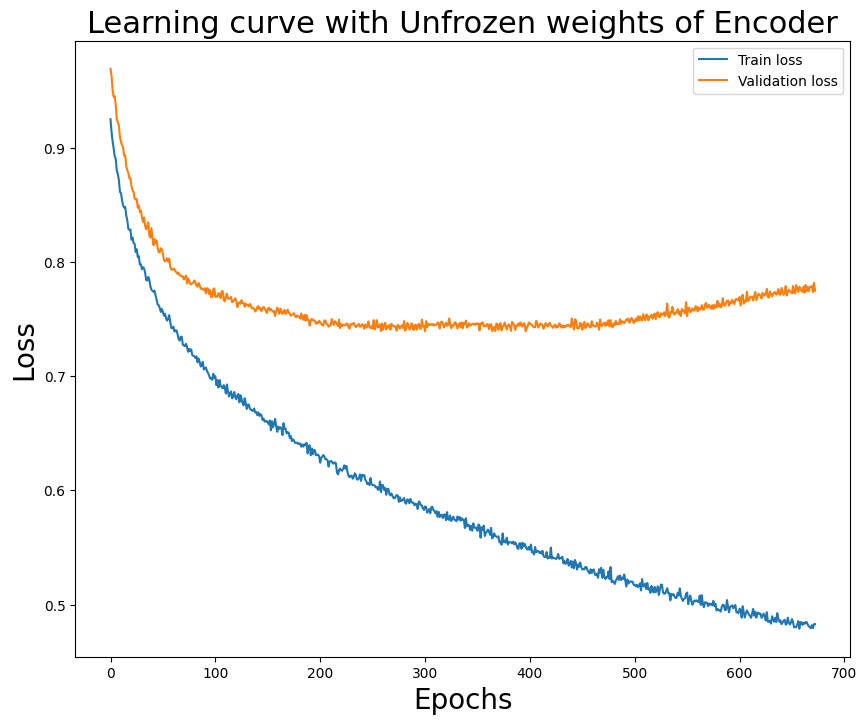

In [59]:
plot_learning_curve(history_wt,"Unfrozen weights of Encoder")

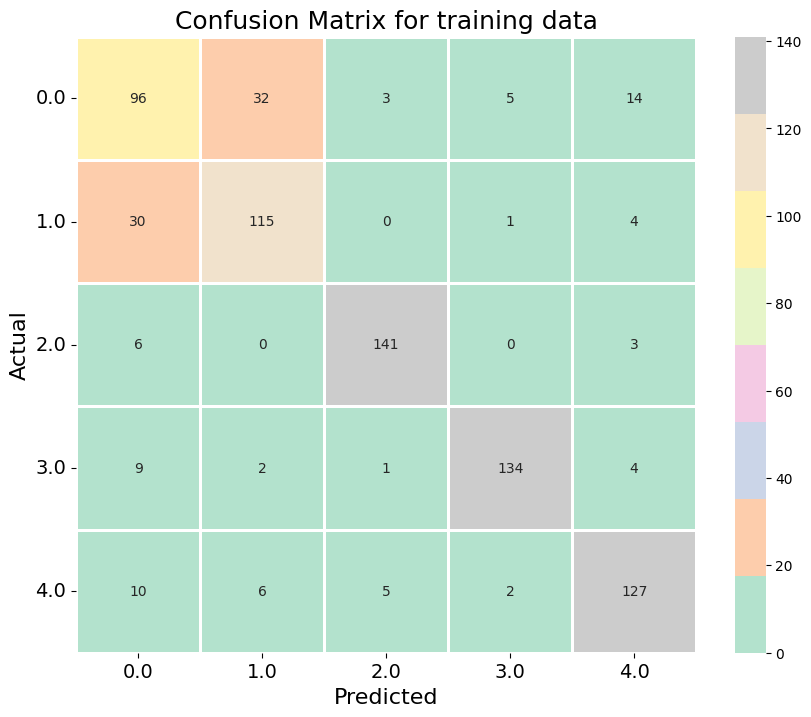

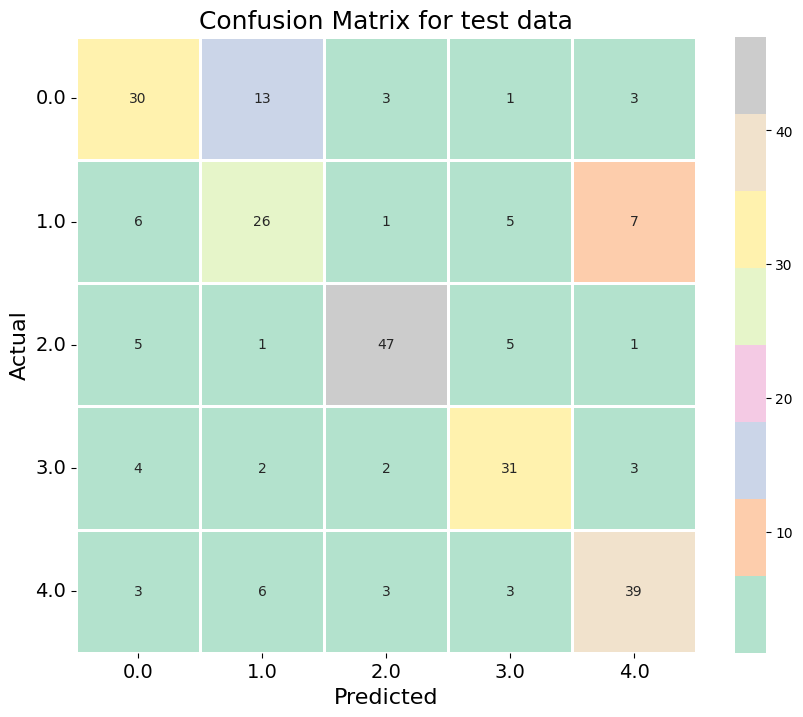

In [74]:
y_pred_test = np.argmax(Fine_tunable_model(X_test),axis=1)
y_pred_train = np.argmax(Fine_tunable_model(X_train),axis=1)

Confusion_matrix(y_train,y_pred_train, "training")
Confusion_matrix(y_test,y_pred_test, "test")